Idea: what would happen if we tried to classify music using one of the well-understood object classification networks, such as the application networks built into Keras? We would need to find some meaningful way of representing musical features in a 299x299 (or 224x224) pixel image. What rendering might work? Spectrally shaded audio waveforms include so much information it can be possible for a DJ to identify and mix in a new track without ever having listened to it. It seems plausible that a rendering designed for fine-grained style comparison might be even more informative.

In [1]:
import os, os.path
import numpy as np
from musictoys import audiofile, analysis

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,3)

In [3]:
audio_files = ["jfb-back_home.wav", "kronfeld-dreamatic.wav", "liberty_chaps-get_up_get_down.wav"]
audio_files = [os.path.join("audio_files", f) for f in audio_files]
audio_clips = [analysis.normalize(*audiofile.read(f)) for f in audio_files]
audio_clips = [data for data, samplerate in audio_clips if samplerate==22050]

In [4]:
clip = audio_clips[0]
print clip.shape, clip.min(), clip.max(), clip.mean()


(661500,) -0.95364237 0.9722892 0.00014017362


In [137]:
def stft(clip, window_len):
    mask = np.hamming(window_len)
    fft_bins = window_len / 2 + 1
    num_frames = int(clip.shape[0] / window_len)
    specgram = np.zeros((num_frames, fft_bins))
    for i in np.arange(num_frames):
        # Get a frame from the clip. Apply hamming function. Take real-FFT.
        # Discard the imaginary component; we only care about magnitude.
        # Coefficients have to be scaled by the window size
        frame = clip[i * window_len:(i+1) * window_len]
        specgram[i,:] = np.abs(np.fft.rfft(mask * frame)) / fft_bins
    return specgram

In [171]:
def plotspectrogram(spec):
    #plt.set_cmap('afmhot')
    plt.imshow(spec.T, interpolation='nearest', aspect='auto')
    plt.gca().invert_yaxis()

In [172]:
def printspecrange(spec, name):
    print "%s range = %.3f..%.3f; mean=%.3f, stdev=%.3f" % (name, spec.min(), spec.max(), spec.mean(), spec.std())


spectrogram range = 0.000..0.268; mean=0.003, stdev=0.009
power spectrum range = 0.000..0.072; mean=0.000, stdev=0.001
loudness (dB) range = -156.316..-11.436; mean=-58.252, stdev=15.161
normalized range = 0.000..0.905; mean=0.515, stdev=0.126


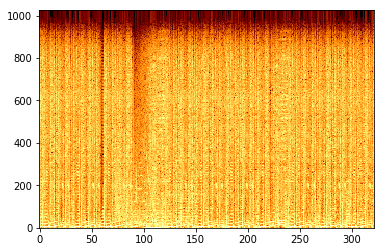

In [173]:
specgram = stft(clip, 2048)
printspecrange(specgram, "spectrogram")
# Convert to power spectrum.
powerspec = np.square(specgram)
printspecrange(powerspec, "power spectrum")
# Get loudness, convert power to decibels.
loudspec = 10.0 * np.log10(powerspec)
printspecrange(loudspec, "loudness (dB)")
# Discard everything below 120 dB and rescale to 0..1.
levelspec = np.clip(1.0 + loudspec / 120.0, 0, 1)
printspecrange(levelspec, "normalized")
plotspectrogram(levelspec)


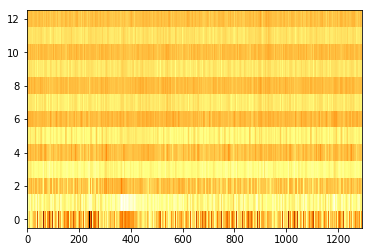

In [177]:
import librosa, librosa.display
mfccs = librosa.feature.mfcc(y=audio_clips[0], sr=22050, n_mfcc=13)
plotspectrogram(mfccs.T)

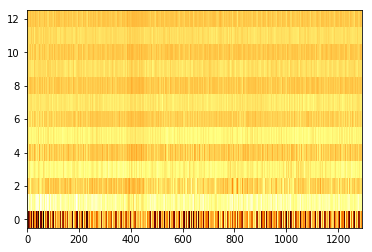

In [178]:
plotspectrogram(librosa.feature.mfcc(y=audio_clips[1], sr=22050, n_mfcc=13).T)

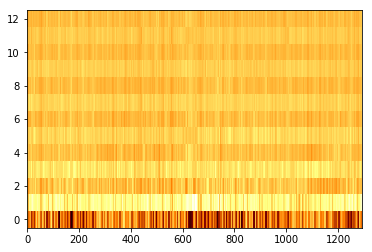

In [179]:
plotspectrogram(librosa.feature.mfcc(y=audio_clips[2], sr=22050, n_mfcc=13).T)